In [36]:
#pip install lightgbm
import lightgbm as lgb
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from sklearn.datasets import load_boston
import tensorflow as tf
from sklearn.model_selection import train_test_split
from pandas import DataFrame 
from Energy_Models.RBFN import RBFN_Model

# Data Preprocessing

In [2]:
df = pd.read_csv('household_power_consumption.txt',sep=';', 
                 parse_dates={'date_time' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='date_time')

# Data Analysis

In [3]:
#  group data by day
data = df.resample('D').sum() 

In [4]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [6]:
df.shape

(2075259, 7)

In [7]:
# filling missing values by the value of one day before 
def fill_missing(data):
    one_day = 24*60
    for row in range(data.shape[0]):
        for col in range(data.shape[1]):
            if np.isnan(data[row,col]):
                data[row,col] = data[row-one_day,col]

In [8]:
fill_missing(df.values)
df.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [9]:
# Compute remaining active power

df['sub_metering_remaining'] = (df.Global_active_power * 1000  / 60 ) - (df.Sub_metering_1 + df.Sub_metering_2 + df.Sub_metering_3)

In [10]:
df = df.resample('D').sum()
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_remaining
date_time,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933333
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666667
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433333
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900000
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800000


In [11]:
df.to_csv('household_power_consumption.csv')
#index >> date-time
df = pd.read_csv('household_power_consumption.csv',parse_dates=['date_time'], index_col= 'date_time')

In [12]:
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_remaining
date_time,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933333
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666667
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433333
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900000
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800000
...,...,...,...,...,...,...,...,...
2010-11-22,2041.536,142.354,345883.85,8660.4,4855.0,2110.0,10136.0,16924.600000
2010-11-23,1577.536,137.450,346428.76,6731.2,1871.0,458.0,7611.0,16352.266667
2010-11-24,1796.248,132.460,345644.59,7559.4,1096.0,2848.0,12224.0,13769.466667


In [13]:
df = df.resample('D').mean()
df.shape

(1442, 8)

In [14]:
def train_test_split(df):
    
    # compute split point
    end_idx = df.shape[0]* 70 // 100
    
    train_data = df.iloc[:end_idx, : ]
    test_data = df.iloc[end_idx:, :]
    
    return train_data, test_data

# Split the data into train and test
X_train, X_test = train_test_split(df)

In [15]:
X_test.shape , X_train.shape

((433, 8), (1009, 8))

In [16]:
def scale_data(train, test):
    scaler = MinMaxScaler().fit(train)
    return scaler.transform(train), scaler.transform(test), scaler

In [17]:
X_train, X_test, scaler = scale_data(X_train, X_test)

In [18]:
def convert_to_supervised(df):

    input_features = []
    ouput_feature = []
    
    len_df = df.shape[0]
    for i in range(len_df):
        
        end_idx = i + 1 
        
        if end_idx > len_df-1:
            break
            
        input_x , output_y = df[i:end_idx, 1:], df[end_idx: end_idx+1, 0]
        input_features.append(input_x)
        ouput_feature.append(output_y)
    
    return np.array(input_features), np.mean(np.array(ouput_feature), axis=1)

In [19]:
# Split the training data into input features and out feature
X_train, Y_train = convert_to_supervised(X_train)
print('Shape of (training data) input features : %s and ouput feature %s' % (X_train.shape, Y_train.shape))

Shape of (training data) input features : (1008, 1, 7) and ouput feature (1008,)


In [20]:
# Split the testing data into input features and out feature
X_test, Y_test = convert_to_supervised(X_test)
print('Shape of (testing data) input features : %s and ouput feature %s' % (X_test.shape, Y_test.shape))

Shape of (testing data) input features : (432, 1, 7) and ouput feature (432,)


In [21]:
X_train

array([[[0.        , 0.        , 0.21100628, ..., 0.04509043,
         0.19965973, 0.20812382]],

       [[0.4990285 , 0.96712049, 0.69522599, ..., 0.34577587,
         0.66148949, 0.58282399]],

       [[0.33132939, 0.97344205, 0.4246181 , ..., 0.21645057,
         0.69864442, 0.28128597]],

       ...,

       [[0.42522564, 0.96791721, 0.32840243, ..., 0.28656371,
         0.6638494 , 0.14893385]],

       [[0.34566689, 0.97415423, 0.21199386, ..., 0.04649434,
         0.46221393, 0.1313267 ]],

       [[0.35070721, 0.97271034, 0.24435292, ..., 0.05384425,
         0.43153504, 0.14793817]]])

In [22]:
Y_train

array([0.6942518 , 0.43190139, 0.31303746, ..., 0.21514682, 0.24844398,
       0.41684177])

In [24]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error, mean_absolute_percentage_error
def root_mean_squared_error(y_true, y_pred):    
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [27]:
n_steps, n_features = X_train.shape[1], X_train.shape[2]
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
RBFN_Model = RBFN_Model(n_steps,n_features).getModel() 

In [28]:
RBFN_Model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 7)]            0         
                                                                 
 build_model_1 (BuildModel)  (None, 1)                 4638      
                                                                 
Total params: 4,638
Trainable params: 4,624
Non-trainable params: 14
_________________________________________________________________


In [29]:
RBFN_Model.compile(optimizer='adam', loss ='mse')
history = RBFN_Model.fit(X_train , Y_train, epochs=200, batch_size=256, verbose= 1,validation_split=0.3)

Epoch 1/200
3/3 [==============================] - 3s 385ms/step - loss: 0.0812 - val_loss: 0.1126
Epoch 2/200
3/3 [==============================] - 0s 60ms/step - loss: 0.0804 - val_loss: 0.1116
Epoch 3/200
3/3 [==============================] - 0s 55ms/step - loss: 0.0793 - val_loss: 0.1105
Epoch 4/200
3/3 [==============================] - 0s 58ms/step - loss: 0.0787 - val_loss: 0.1095
Epoch 5/200
3/3 [==============================] - 0s 57ms/step - loss: 0.0771 - val_loss: 0.1084
Epoch 6/200
3/3 [==============================] - 0s 55ms/step - loss: 0.0762 - val_loss: 0.1073
Epoch 7/200
3/3 [==============================] - 0s 53ms/step - loss: 0.0751 - val_loss: 0.1062
Epoch 8/200
3/3 [==============================] - 0s 56ms/step - loss: 0.0739 - val_loss: 0.1050
Epoch 9/200
3/3 [==============================] - 0s 57ms/step - loss: 0.0733 - val_loss: 0.1039
Epoch 10/200
3/3 [==============================] - 0s 50ms/step - loss: 0.0727 - val_loss: 0.1027
Epoch 11/200
3/3 [

Epoch 84/200
3/3 [==============================] - 0s 50ms/step - loss: 0.0454 - val_loss: 0.0468
Epoch 85/200
3/3 [==============================] - 0s 50ms/step - loss: 0.0452 - val_loss: 0.0464
Epoch 86/200
3/3 [==============================] - 0s 50ms/step - loss: 0.0450 - val_loss: 0.0460
Epoch 87/200
3/3 [==============================] - 0s 52ms/step - loss: 0.0448 - val_loss: 0.0456
Epoch 88/200
3/3 [==============================] - 0s 48ms/step - loss: 0.0446 - val_loss: 0.0452
Epoch 89/200
3/3 [==============================] - 0s 50ms/step - loss: 0.0445 - val_loss: 0.0448
Epoch 90/200
3/3 [==============================] - 0s 52ms/step - loss: 0.0443 - val_loss: 0.0444
Epoch 91/200
3/3 [==============================] - 0s 51ms/step - loss: 0.0441 - val_loss: 0.0441
Epoch 92/200
3/3 [==============================] - 0s 50ms/step - loss: 0.0439 - val_loss: 0.0437
Epoch 93/200
3/3 [==============================] - 0s 200ms/step - loss: 0.0437 - val_loss: 0.0433
Epoch 94/

3/3 [==============================] - 0s 50ms/step - loss: 0.0336 - val_loss: 0.0290
Epoch 167/200
3/3 [==============================] - 0s 51ms/step - loss: 0.0335 - val_loss: 0.0289
Epoch 168/200
3/3 [==============================] - 0s 51ms/step - loss: 0.0334 - val_loss: 0.0288
Epoch 169/200
3/3 [==============================] - 0s 50ms/step - loss: 0.0333 - val_loss: 0.0286
Epoch 170/200
3/3 [==============================] - 0s 50ms/step - loss: 0.0332 - val_loss: 0.0285
Epoch 171/200
3/3 [==============================] - 0s 52ms/step - loss: 0.0331 - val_loss: 0.0284
Epoch 172/200
3/3 [==============================] - 0s 48ms/step - loss: 0.0330 - val_loss: 0.0283
Epoch 173/200
3/3 [==============================] - 0s 50ms/step - loss: 0.0329 - val_loss: 0.0282
Epoch 174/200
3/3 [==============================] - 0s 51ms/step - loss: 0.0328 - val_loss: 0.0281
Epoch 175/200
3/3 [==============================] - 0s 51ms/step - loss: 0.0327 - val_loss: 0.0280
Epoch 176/200


In [30]:
Y_pred_train = RBFN_Model.predict(X_train)
Y_pred_test = RBFN_Model.predict(X_test)

14/14 [==============================] - 0s 3ms/step


In [31]:
print('Train   RMSE  value for RBFN Model  : %.3f ' % root_mean_squared_error(Y_train, Y_pred_train))
print('Train   MSE   value for RBFN Model  : %.3f ' % mean_squared_error(Y_train, Y_pred_train))
print('Train   R2    value for RBFN Model  : %.3f ' % r2_score(Y_train, Y_pred_train))
print('Train   MAPE  value for RBFN Model  : %.3f ' % mean_absolute_percentage_error(Y_train, Y_pred_train))
print('Train   RMLSE value for RBFN Model  : %.3f ' % mean_squared_log_error(Y_train, Y_pred_train))
print('Train   MAE   value for RBFN Model  : %.3f ' % mean_absolute_error(Y_train, Y_pred_train))
print('---------------------------------------------')
print('Test    RMSE  value for RBFN Model  : %.3f ' % root_mean_squared_error(Y_test, Y_pred_test))
print('Test    MSE   value for RBFN Model  : %.3f ' % mean_squared_error(Y_test, Y_pred_test))
print('Test    R2    value for RBFN Model  : %.3f ' % r2_score(Y_test, Y_pred_test))
print('Test    MAPE  value for RBFN Model  : %.3f ' % mean_absolute_percentage_error(Y_test, Y_pred_test))
print('Test    RMLSE value for RBFN Model  : %.3f ' % mean_squared_log_error(Y_test, Y_pred_test))
print('Test    MAE   value for RBFN Model  : %.3f ' % mean_absolute_error(Y_test, Y_pred_test))

Train   RMSE  value for RBFN Model  : 0.170 
Train   MSE   value for RBFN Model  : 0.029 
Train   R2    value for RBFN Model  : -0.436 
Train   MAPE  value for RBFN Model  : 1712373608126.231 
Train   RMLSE value for RBFN Model  : 0.018 
Train   MAE   value for RBFN Model  : 0.140 
---------------------------------------------
Test    RMSE  value for RBFN Model  : 0.138 
Test    MSE   value for RBFN Model  : 0.019 
Test    R2    value for RBFN Model  : -0.723 
Test    MAPE  value for RBFN Model  : 0.639 
Test    RMLSE value for RBFN Model  : 0.012 
Test    MAE   value for RBFN Model  : 0.113 


In [32]:
RBFN_Model.evaluate(X_train,Y_train)

32/32 [==============================] - 0s 4ms/step - loss: 0.0290


0.029003214091062546

In [33]:
RBFN_Model.evaluate(X_test,Y_test)

14/14 [==============================] - 0s 4ms/step - loss: 0.0190


0.018953753635287285

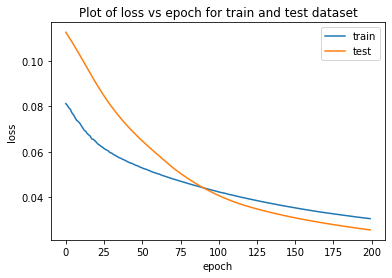

In [34]:
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()